***


# Projet : Reed-Salomon, QR code et correction d’erreur
***
***


Jean-Loup Mellion  
Gatien Da Rocha

**/!\ Typage fort utilisé, Python 3.10 minimum requis**

In [1588]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import itertools
from collections import Counter

# Rappel interpolation polynomiale

Avant de s'attaquer a Reed-Salomon, il est important de rappeler le principe de l'interpolation polynomiale. L'interpolation polynomiale est une méthode mathématique permettant de trouver un polynôme qui passe par un ensemble de points donnés.

Pour cela, nous allons utiliser la méthode de Lagrange. Cette méthode permet de trouver un polynôme de degré $n-1$ passant par $n$ points donnés.

### Polynôme de Lagrange

In [1589]:
def polynome_base_lagrange(var_x: int, i: int, x_array: np.ndarray, y_array: np.ndarray) -> float:
    """
    Cette fonction calcule le polynome de base de lagrange, c'est à dire le produit des termes (x-x_j)/(x_i-x_j) pour j != i
    :param var_x: int, la valeur de x pour laquelle on veut calculer le polynome de base
    :param x_array: np.ndarray, les valeurs de x
    :param y_array: np.ndarray, les valeurs de y
    :param i: int, l'indice du polynome de base
    :return: float, le polynome de base de lagrange
    """
    res = 1
    for j in range(len(x_array)):
        if j != i:
            res = res * (var_x - x_array[j]) / (x_array[i] - x_array[j])
    return y_array[i]*res

In [1590]:
def poly_lagrange(var_x: int, x_array: np.ndarray, y_array: np.ndarray) -> float:
    """
    Cette fonction calcule le polynome de lagrange pour un x donné, c'est à dire la somme des polynomes de base de lagrange
    :param var_x: int, la valeur de x pour laquelle on veut calculer le polynome de lagrange
    :param x_array: np.ndarray, les valeurs de x
    :param y_array: np.ndarray, les valeurs de y
    """
    sum = 0
    for i in range(len(x_array)):
        sum = sum + polynome_base_lagrange(var_x, i, x_array, y_array)
    return sum

Nous allons maintenant tester la méthode de Lagrange sur un exemple simple.

In [1591]:
# On défnit le message à envoyer
message_original = [6, 9, 4, 2, 0]

# On encode le message
def encode_message(message: list, t: int) -> tuple:
    """
    Cette fonction encode un message en rajoutant de la redondance pour pouvoir corriger des erreurs
    :param message: list, le message à encoder
    :param t: int, le nombre d'erreurs que l'on veut pouvoir corriger
    :return: tuple, les valeurs de x et de y
    """
    x_array = []
    for i in range(len(message)):
        x_array.append(i+1)

    y_array = message
    for i in range(t):
        y_array.append(poly_lagrange(len(x_array)+i+1, np.array(x_array), np.array(message)))

    for i in range(t):
        x_array.append(len(x_array)+1)
    return x_array, y_array

x_array, y_array = encode_message(message_original, 2)

print("x_array:", x_array)
print("y_array:", y_array)

x_array: [1, 2, 3, 4, 5, 6, 7]
y_array: [6, 9, 4, 2, 0, -19.0, -86.0]


In [1592]:
# Ensuite on peut retirer 1 ou 2 valeurs du message pour simuler des erreurs
message_erreur = y_array.copy()
message_erreur[0] = 0

print("message_erreur:", message_erreur)

def detect_erreur(k: int, y_array: list) -> bool:
    """
    Cette fonction détecte si il y a une erreur dans le message
    :param k: int, le nombre de valeurs à retirer du message
    :param y_array: list, les valeurs de y
    :return: bool, True si il y a une erreur, False sinon
    """
    y_array = np.asarray(y_array)
    xt = np.arange(len(y_array))
    list_s = list(itertools.combinations(xt, k))
    res = []
    erreur = False
    for s in list_s:
        s = list(s)
        resPol = list(poly_lagrange(xt,s,y_array[s]))
        if resPol not in res:
            res.append(resPol)
    if len(res) > 1:
        erreur = True
    return erreur

def correct_message(k: int, y_array: np.ndarray) -> list:
    """
    Cette fonction corrige un message
    :param k: int, 
    :param y_array: np.ndarray, les valeurs de y
    """
    y_array = np.asarray(y_array)
    erreur = detect_erreur(k, y_array)
    if erreur:
        res_map = Counter()
        combinaison = itertools.combinations(range(len(y_array)), k)
        for c in combinaison:
            c = list(c)
            pol = []
            for i in range(k):
                pol.append(poly_lagrange(i, c, y_array[c]))
            res_map[tuple(pol)] += 1
        most_common = res_map.most_common(1)[0][0]
        return most_common
    return y_array

corrected_message = correct_message(5, message_erreur)
print("corrected_message:", corrected_message)

message_erreur: [0, 9, 4, 2, 0, -19.0, -86.0]
corrected_message: (6.0, 9.0, 4.0, 2.0, 0.0)


# Reed-Solomon

Un des principaux défis de l'interpolation polynomiale appliquée aux messages codés est que les valeurs $y$ des points de redondance peuvent être trop grandes. Par exemple, pour encoder un message avec 1 octet par point, $y$ doit être compris entre 0 et 255, mais un point de redondance peut dépasser cette plage.

Pour résoudre ce problème, on utilise les codes de Reed-Solomon, qui limitent la taille des $y$ grâce à des opérations modulo dans un corp fini, appelé Galois Field (GF).

## Arithmétique des Corps Finis

### Introduction aux Corps de Galois $GF(2^8)$

Nous voulons définir les opérations d'addition, de soustraction, de multiplication et de division pour des octets (8 bits) en produisant toujours des résultats de 8 bits pour éviter les débordements. Nous utilisons des opérations modulo 256, ce qui fonctionne bien sauf pour la division.

Un corp fini, ou Galois Field, est un ensemble de nombres avec six propriétés : fermeture, associativité, commutativité, distributivité, élément neutre et élément inverse. Par exemple, les réels $\mathbb{R}$ forment un corp, mais les entiers $\mathbb{Z}$ ne le sont pas car la division n'y est pas toujours définie.

En utilisant un modulo d'un nombre premier ou d'une puissance de nombre premier, chaque élément a un inverse multiplicatif, ce qui résout les problèmes de division. $GF(2^8)$ est particulièrement intéressant car une chaîne de 8 bits peut représenter 256 valeurs (0 à 255).

### Représentation Polynomiale

Dans \( GF(2^8) \), nous utilisons des polynômes de 8 coefficients binaires. Par exemple, le nombre 170 en $GF(2^8)$ est équivalent à 10101010 en binaire, soit $x^7 + x^5 + x^3 + x$. Ces représentations sont équivalentes, l'une étant décimale et l'autre binaire.

Les codes de Reed-Solomon utilisent ces propriétés pour maintenir les valeurs $y$ dans des limites acceptables, permettant des opérations arithmétiques fiables sur les octets de données.

Video explicative : https://www.youtube.com/watch?v=1pQJkt7-R4Q

### Gestion des erreurs python

Comme il y a beaucoup d'endroit ou une erreur peut se produire, on va utiliser des exceptions pour les gérer. On va donc créer une classe d'exception pour les erreurs de Reed-Salomon.

In [1593]:
class ReedSolomonError(Exception):
    """
    Cette classe permet de gérer les erreurs dans le code Reed-Solomon
    """
    pass

### Initialisation de la table de Galois GF(2^8)

Implémenté à partir de : https://en.wikiversity.org/wiki/Reed%E2%80%93Solomon_codes_for_coders#Multiplication_with_logarithms, et d'autres sources.

In [1594]:
# On a besoin de multiplier des nombres dans un corp de Galois pour initialiser les tables
def gf_multiplication_noLUT(x: int, y: int, prim: int = 0) -> int:
    """
    Multiplication dans le corp de Galois sans table de recherche (LUT).

    :param x: int, premier opérande
    :param y: int, deuxième opérande
    :param prim: int, polynôme primitif
    :return: int, résultat de la multiplication
    """
    def cl_mult(x: int, y: int) -> int:
        z = 0
        i = 0
        while (y >> i) > 0:
            if y & (1 << i):
                z ^= x << i
            i += 1
        return z

    def bit_length(n: int) -> int:
        bits = 0
        while n >> bits: 
            bits += 1
        return bits

    def cl_div(dividend: int, divisor: int = None) -> int:
        dl1 = bit_length(dividend)
        dl2 = bit_length(divisor)
        if dl1 < dl2:
            return dividend
        for i in range(dl1 - dl2, -1, -1):
            if dividend & (1 << (i + dl2 - 1)):
                dividend ^= divisor << i
        return dividend

    result = cl_mult(x, y)
    if prim > 0:
        result = cl_div(result, prim)
    return result

gf_exp = [0] * 512 # 2^8 * 2
gf_log = [0] * 256 # 2^8

# On initialise les tables de logarithme et d'exponentiation pour les opérations dans le corp de Galois
def init_tables(prim: int = 0x11d) -> list[list[int]]:
    """
    Initialisation des tables logarithmique et exponentielle pour le corp de Galois.

    :param prim: int, polynôme primitif
    :return: list[list[int]], tables logarithmique et exponentielle
    """
    global gf_exp, gf_log
    gf_exp = [0] * 512
    gf_log = [0] * 256
    x = 1
    for i in range(255):
        gf_exp[i] = x
        gf_log[x] = i
        x = gf_multiplication_noLUT(x, 2, prim)
    for i in range(255, 512):
        gf_exp[i] = gf_exp[i - 255]
    return [gf_log, gf_exp]

### Operations sur GF(2^8)

Implémenté à partir de : https://en.wikiversity.org/wiki/Reed%E2%80%93Solomon_codes_for_coders#Finite_field_arithmetic, et d'autres sources.

On implémente pas les additions et soustractions car on peut les faire simplement avec les opérations XOR. (a+b = a^b)

In [1595]:
# Multiplication plus rapide avec les tables de logarithme et d'exponentiation
def gf_multiplication(x: int, y: int) -> int:
    """
    Multiplication dans le corp de Galois avec tables de recherche (LUT).

    :param x: int, premier opérande
    :param y: int, deuxième opérande
    :return: int, résultat de la multiplication
    """
    if x == 0 or y == 0:
        return 0
    return gf_exp[gf_log[x] + gf_log[y]]

def gf_division(x: int, y: int) -> int:
    """
    Division dans le corp de Galois.

    :param x: int, numérateur
    :param y: int, dénominateur
    :return: int, résultat de la division
    :raises ZeroDivisionError: si y est zéro
    """
    if y == 0:
        raise ZeroDivisionError()
    if x == 0:
        return 0
    return gf_exp[(gf_log[x] + 255 - gf_log[y]) % 255]

def gf_power(x: int, power: int) -> int:
    """
    Exponentiation dans le corp de Galois.

    :param x: int, base
    :param power: int, exposant
    :return: int, résultat de l'exponentiation
    """
    return gf_exp[(gf_log[x] * power) % 255]

def gf_inverse(x: int) -> int:
    """
    Inverse dans le corp de Galois.

    :param x: int, élément dont on veut l'inverse
    :return: int, inverse de x
    """
    return gf_exp[255 - gf_log[x]]

def gf_poly_scale(p: list[int], x: int) -> list[int]:
    """
    Multiplication d'un polynôme par un scalaire dans le corp de Galois.

    :param p: list[int], polynôme
    :param x: int, scalaire
    :return: list[int], polynôme résultant
    """
    return [gf_multiplication(p[i], x) for i in range(len(p))]

def gf_poly_addition(p: list[int], q: list[int]) -> list[int]:
    """
    Addition de deux polynômes dans le corp de Galois.

    :param p: list[int], premier polynôme
    :param q: list[int], deuxième polynôme
    :return: list[int], polynôme résultant
    """
    r = [0] * max(len(p), len(q))
    for i in range(len(p)):
        r[i + len(r) - len(p)] = p[i]
    for i in range(len(q)):
        r[i + len(r) - len(q)] ^= q[i]
    return r

def gf_poly_multiplication(p: list[int], q: list[int]) -> list[int]:
    """
    Multiplication de deux polynômes dans le corp de Galois.

    :param p: list[int], premier polynôme
    :param q: list[int], deuxième polynôme
    :return: list[int], polynôme résultant
    """
    r = [0] * (len(p) + len(q) - 1)
    for j in range(len(q)):
        for i in range(len(p)):
            r[i + j] ^= gf_multiplication(p[i], q[j])
    return r

def gf_poly_division(dividend: list[int], divisor: list[int]) -> tuple[list[int], list[int]]:
    """
    Division de deux polynômes dans le corp de Galois.

    :param dividend: list[int], polynôme dividende
    :param divisor: list[int], polynôme diviseur
    :return: tuple[list[int], list[int]], quotient et reste de la division
    """
    msg_out = list(dividend)
    for i in range(len(dividend) - (len(divisor) - 1)):
        coef = msg_out[i]
        if coef != 0:
            for j in range(1, len(divisor)):
                if divisor[j] != 0:
                    msg_out[i + j] ^= gf_multiplication(divisor[j], coef)
    separator = -(len(divisor) - 1)
    return msg_out[:separator], msg_out[separator:]

def gf_poly_evaluation(poly: list[int], x: int) -> int:
    """
    Évaluation d'un polynôme dans le corp de Galois à une valeur donnée.

    :param poly: list[int], polynôme
    :param x: int, valeur d'évaluation
    :return: int, résultat de l'évaluation
    """
    y = poly[0]
    for i in range(1, len(poly)):
        y = gf_multiplication(y, x) ^ poly[i]
    return y

In [1596]:
# Tests pour les opérations sur GF(2^8) 
def test_gf_operations():
    """
    Cette fonction teste les opérations sur GF(2^8)
    Validé avec https://hp.vector.co.jp/authors/VA021385/galois_calc.htm
    """
    
    # Multiplication
    assert gf_multiplication(15, 27) == 153
    assert gf_multiplication(0, 15) == 0
    assert gf_multiplication(15, 0) == 0
    assert gf_multiplication(15, 1) == 15
    assert gf_multiplication(42, 69) == 208
    
    # Division
    assert gf_division(188, 15) == 216
    assert gf_division(188, 1) == 188
    assert gf_division(15, 188) == 16
    assert gf_division(42, 69) == 227
    assert gf_division(69, 42) == 240
    
    # Puissance
    assert gf_power(15, 0) == 1
    assert gf_power(15, 1) == 15
    assert gf_power(15, 2) == 85
    assert gf_power(15, 3) == 36
    assert gf_power(42, 69) == 208
    
    # Inversion
    assert gf_inverse(15) == 150

    print("Tous les tests passent")

init_tables()
test_gf_operations()

Tous les tests passent


### Encodage

In [1597]:
def rs_generator_poly(n_symboles: int) -> list[int]:
    """
    Génération du polynôme générateur pour le code de Reed-Solomon.

    :param nsym: int, nombre de symboles de correction d'erreur
    :return: list[int], polynôme générateur
    """
    g = [1]
    for i in range(n_symboles):
        g = gf_poly_multiplication(g, [1, gf_power(2, i)])
    return g

def rs_encode_message(message_in: list[int], n_symboles: int) -> list[int]:
    """
    Encodage d'un message avec le code de Reed-Solomon.

    :param msg_in: list[int], message à encoder
    :param nsym: int, nombre de symboles de correction d'erreur
    :return: list[int], message encodé
    :raises ValueError: si le message est trop long
    """
    if len(message_in) + n_symboles > 255:
        raise ValueError("Le message est trop long")
    gen = rs_generator_poly(n_symboles)
    message_out = [0] * (len(message_in) + len(gen) - 1)
    message_out[:len(message_in)] = message_in

    for i in range(len(message_in)):
        coef = message_out[i]
        if coef != 0:
            for j in range(1, len(gen)):
                message_out[i + j] ^= gf_multiplication(gen[j], coef)

    message_out[:len(message_in)] = message_in
    return message_out

### Decodage (correction d'erreurs)

In [1598]:
def rs_calc_syndromes(message: list[int], n_symboles: int) -> list[int]:
    """
    Calcul des syndromes pour le code de Reed-Solomon.

    :param msg: list[int], message encodé
    :param nsym: int, nombre de symboles de correction d'erreur
    :return: list[int], syndromes
    """
    syndromes = [0] * n_symboles
    for i in range(n_symboles):
        syndromes[i] = gf_poly_evaluation(message, gf_power(2, i))
    return [0] + syndromes

def rs_find_errata_locator(error_positions: list[int]) -> list[int]:
    """
    Trouver le localisateur d'erreurs pour le code de Reed-Solomon.

    :param e_pos: list[int], positions des erreurs
    :return: list[int], polynôme localisateur d'erreurs
    """
    error_localisations = [1]
    for i in error_positions:
        error_localisations = gf_poly_multiplication(error_localisations, gf_poly_addition([1], [gf_power(2, i), 0]))
    return error_localisations

def rs_find_error_evaluator(syndromes: list[int], error_localisations: list[int], n_symboles: int) -> list[int]:
    """
    Trouver l'évaluateur d'erreurs pour le code de Reed-Solomon.

    :param synd: list[int], syndromes
    :param err_loc: list[int], localisateur d'erreurs
    :param nsym: int, nombre de symboles de correction d'erreur
    :return: list[int], évaluateur d'erreurs
    """
    _, remainder = gf_poly_division(gf_poly_multiplication(syndromes, error_localisations), ([1] + [0] * (n_symboles + 1)))
    return remainder

def rs_correct_errata(message: list[int], syndromes: list[int], error_positions: list[int]) -> list[int]:
    """
    Correction des erreurs dans le message pour le code de Reed-Solomon.

    :param msg_in: list[int], message encodé avec erreurs
    :param synd: list[int], syndromes
    :param err_pos: list[int], positions des erreurs
    :return: list[int], message corrigé
    :raises ReedSolomonError: si une erreur de magnitude ne peut pas être trouvée
    """
    coef_positions = [len(message) - 1 - p for p in error_positions]
    error_localisations = rs_find_errata_locator(coef_positions)
    error_evaluations = rs_find_error_evaluator(syndromes[::-1], error_localisations, len(error_localisations) - 1)[::-1]

    X = []
    for i in range(len(coef_positions)):
        l = 255 - coef_positions[i]
        X.append(gf_power(2, -l))

    E = [0] * len(message)
    Xlength = len(X)
    for i, Xi in enumerate(X):
        Xi_inv = gf_inverse(Xi)
        err_loc_prime_tmp = []
        for j in range(Xlength):
            if j != i:
                err_loc_prime_tmp.append(1 ^ gf_multiplication(Xi_inv, X[j]))
        err_loc_prime = 1
        for coef in err_loc_prime_tmp:
            err_loc_prime = gf_multiplication(err_loc_prime, coef)

        y = gf_poly_evaluation(error_evaluations[::-1], Xi_inv)
        y = gf_multiplication(gf_power(Xi, 1), y)

        if err_loc_prime == 0:
            raise ReedSolomonError("Impossible de trouver la magnitude de l'erreur")

        magnitude = gf_division(y, err_loc_prime)
        E[error_positions[i]] = magnitude

    message = gf_poly_addition(message, E)
    return message

def rs_find_error_locator(syndromes: list[int], n_symboles: int, erase_locations: list[int] | None = None, erase_count: int = 0) -> list[int]:
    """
    Trouver le localisateur d'erreurs pour le code de Reed-Solomon avec gestion des effacements.

    :param synd: list[int], syndromes
    :param nsym: int, nombre de symboles de correction d'erreur
    :param erase_loc: list[int] | None, localisateur d'effacements
    :param erase_count: int, nombre d'effacements
    :return: list[int], localisateur d'erreurs
    :raises ReedSolomonError: si trop d'erreurs à corriger
    """
    if erase_locations:
        error_localisations = list(erase_locations)
        old_localisations = list(erase_locations)
    else:
        error_localisations = [1]
        old_localisations = [1]

    synd_shift = len(syndromes) - n_symboles

    for i in range(n_symboles - erase_count):
        if erase_locations:
            K = erase_count + i + synd_shift
        else:
            K = i + synd_shift

        delta = syndromes[K]
        for j in range(1, len(error_localisations)):
            delta ^= gf_multiplication(error_localisations[-(j + 1)], syndromes[K - j])

        old_localisations = old_localisations + [0]

        if delta != 0:
            if len(old_localisations) > len(error_localisations):
                new_loc = gf_poly_scale(old_localisations, delta)
                old_localisations = gf_poly_scale(error_localisations, gf_inverse(delta))
                error_localisations = new_loc

            error_localisations = gf_poly_addition(error_localisations, gf_poly_scale(old_localisations, delta))

    while len(error_localisations) and error_localisations[0] == 0:
        del error_localisations[0]

    errors = len(error_localisations) - 1
    if (errors - erase_count) * 2 + erase_count > n_symboles:
        raise ReedSolomonError("Trop d'erreurs à corriger")
    return error_localisations

def rs_find_errors(error_localisations: list[int], n_message: int) -> list[int]:
    """
    Trouver les erreurs dans le message pour le code de Reed-Solomon.

    :param err_loc: list[int], localisateur d'erreurs
    :param nmess: int, taille du message
    :return: list[int], positions des erreurs
    :raises ReedSolomonError: si trop d'erreurs trouvées
    """
    errs = len(error_localisations) - 1
    err_pos = []
    for i in range(n_message):
        if gf_poly_evaluation(error_localisations, gf_power(2, i)) == 0:
            err_pos.append(n_message - 1 - i)
    if len(err_pos) != errs:
        raise ReedSolomonError("Trop (ou pas assez) d'erreurs trouvées par la recherche de Chien pour le polynôme localisateur d'erreurs !")
    return err_pos

def rs_forney_syndromes(syndromes: list[int], error_positions: list[int], n_message: int) -> list[int]:
    """
    Calcul des syndromes de Forney pour le code de Reed-Solomon.

    :param synd: list[int], syndromes
    :param pos: list[int], positions des erreurs
    :param nmess: int, taille du message
    :return: list[int], syndromes de Forney
    """
    erase_pos_reversed = [n_message - 1 - p for p in error_positions]
    forney_syndromes = list(syndromes[1:])
    for i in range(len(error_positions)):
        x = gf_power(2, erase_pos_reversed[i])
        for j in range(len(forney_syndromes) - 1):
            forney_syndromes[j] = gf_multiplication(forney_syndromes[j], x) ^ forney_syndromes[j + 1]
    return forney_syndromes

def rs_correct_msg(message_in: list[int], n_symboles: int, erase_positions: list[int] | None = None) -> tuple[list[int], list[int]]:
    """
    Correction d'un message encodé avec le code de Reed-Solomon.

    :param msg_in: list[int], message encodé avec erreurs
    :param nsym: int, nombre de symboles de correction d'erreur
    :param erase_pos: list[int] | None, positions des effacements
    :return: tuple[list[int], list[int]], message corrigé et code de correction
    :raises ValueError: si le message est trop long
    :raises ReedSolomonError: si le message ne peut pas être corrigé
    """
    if len(message_in) > 255:
        raise ValueError("Le message est trop long")

    message_out = list(message_in)
    if erase_positions is None:
        erase_positions = []
    else:
        for e_pos in erase_positions:
            message_out[e_pos] = 0
    if len(erase_positions) > n_symboles:
        raise ReedSolomonError("Trop d'effacements à corriger")

    syndromes = rs_calc_syndromes(message_out, n_symboles)
    if max(syndromes) == 0:
        return message_out[:-n_symboles], message_out[-n_symboles:]

    fsynd = rs_forney_syndromes(syndromes, erase_positions, len(message_out))
    error_localisations = rs_find_error_locator(fsynd, n_symboles, erase_count=len(erase_positions))
    error_positions = rs_find_errors(error_localisations[::-1], len(message_out))
    if error_positions is None:
        raise ReedSolomonError("Impossible de localiser l'erreur")

    message_out = rs_correct_errata(message_out, syndromes, erase_positions + error_positions)
    syndromes = rs_calc_syndromes(message_out, n_symboles)
    if max(syndromes) > 0:
        raise ReedSolomonError("Impossible de corriger le message")
    return message_out[:-n_symboles], message_out[-n_symboles:]

### Test complet

In [1599]:
n = 20 # longueur du message avec redondance
k = 11 # longueur du message original
message_original = "ceci est un message"
print("Message original: %s" % message_original)

init_tables()

# On encode le message
message_encode = rs_encode_message([ord(x) for x in message_original], n - k)
print("Original encodé: %s" % message_encode)

# On simule des erreurs
nb_erreurs = 4
message_erreur = message_encode.copy()
for i in range(nb_erreurs):
    message_erreur[i] = 0
message_encode = message_erreur.copy()
print("Message corrompu: %s" % message_encode)

# On corrige le message
corrected_message, corrected_ecc = rs_correct_msg(message_encode, n - k, erase_positions=[0, 1, 2])
print("Message corrigé encodé: %s" % corrected_message)
print("Message corrigé:", ''.join([chr(x) for x in corrected_message]))

Message original: ceci est un message
Original encodé: [99, 101, 99, 105, 32, 101, 115, 116, 32, 117, 110, 32, 109, 101, 115, 115, 97, 103, 101, 0, 190, 238, 248, 186, 109, 240, 139, 58]
Message corrompu: [0, 0, 0, 0, 32, 101, 115, 116, 32, 117, 110, 32, 109, 101, 115, 115, 97, 103, 101, 0, 190, 238, 248, 186, 109, 240, 139, 58]
Message corrigé encodé: [99, 101, 99, 105, 32, 101, 115, 116, 32, 117, 110, 32, 109, 101, 115, 115, 97, 103, 101]
Message corrigé: ceci est un message


# Application dans les QR codes et autres en correction d'erreur

### Function helper pour dessiner une matrice

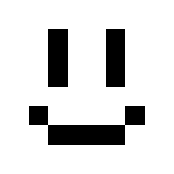

In [1600]:
def draw_matrice(array: np.ndarray, pixel_size: int = 2):
    """
    Cette fonction dessine un tableau 2D de booléens
    :param array: np.ndarray, le tableau 2D de booléens
    :param pixel_size: int, la taille d'un pixel
    """
    array = np.logical_not(array)
    plt.figure(figsize=(array.shape[1]*pixel_size/array.shape[0], pixel_size))
    plt.imshow(array, cmap='gray')
    plt.axis('off')
    plt.show()

array = [
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
]

array = np.array(array, dtype=bool)
draw_matrice(array)

### Structure d'un QR code

Les QR codes ont une structure bien précise, avec des zones de calibrage, des zones de format, des zones de timing, des zones de données, des zones de correction d'erreur, etc.

![QR code](qr-code-structure.png)

Ici, nous allons seulement nous intéresser aux zones de données et de correction d'erreur, qui utilisent le code de Reed-Salomon.

![QR code](qr-code-pattern.png)

Et pour simplifier on va suivre une structure bien plus simple, en encodant simplement un message dans une matrice de 2 dimensions, et en ajoutant des points de redondances pour corriger les erreurs.

### Encodage du message dans une matrice

Ici, on va simplement encoder un message dans une matrice de 2 dimensions, en ajoutant des points de redondances pour corriger les erreurs.  
On spécifie la largeur de la matrice, la hauteur dépends de la taille du message.  
On ajoute aussi un mask en forme de mosaique comme dans certains QR codes.  

In [1601]:
def encode_message(message: str, n_symboles: int, width: int, mask: bool) -> np.ndarray:
    """
    Cette fonction encode un message en une array 2D de booléens
    :param message: str, le message à encoder
    :param n_symboles: int, le nombre de symboles de correction d'erreur
    :param width: int, la largeur de l'image
    :return: np.ndarray, la matrice 2D de booléens
    """
    init_tables()
    # Convertir le message en une liste d'octets
    message_bytes = [ord(x) for x in message]
    
    # Encoder le message avec Reed-Solomon
    encoded_message = rs_encode_message(message_bytes, n_symboles)
    
    # Convertir le message encodé en une chaîne de bits
    bit_string = ''.join([format(byte, '08b') for byte in encoded_message])
    
    # Calculer la hauteur de la matrice
    height = len(bit_string) // width + (1 if len(bit_string) % width != 0 else 0)
    
    # Créer la matrice 2D de booléens
    matrix = np.zeros((height, width), dtype=bool)
    
    # Remplir la matrice avec les bits du message encodé
    for i, bit in enumerate(bit_string):
        row = i // width
        col = i % width
        matrix[row, col] = int(bit)

    # On ajoute un simple masque comme le QR code (mosaique)
    if mask:
        for i in range(0, height, 2):
            for j in range(0, width, 2):
                matrix[i, j] = 1 if matrix[i, j] == 0 else 0

    return matrix

In [1602]:
def decode_message(matrix: np.ndarray, n_symboles: int, mask: bool) -> str:
    """
    Cette fonction décode un message à partir d'une array 2D de booléens
    :param matrix: np.ndarray, la matrice 2D de booléens
    :param n_symboles: int, le nombre de symboles de correction d'erreur
    :param mask: bool, si un masque a été utilisé
    :return: str, le message décodé
    """
    # On retire le masque
    if mask:
        for i in range(0, matrix.shape[0], 2):
            for j in range(0, matrix.shape[1], 2):
                matrix[i, j] = 1 if matrix[i, j] == 0 else 0

    # Convertir la matrice en une chaîne de bits
    bit_string = ''.join([str(int(x)) for x in matrix.flatten()])
    
    # Convertir la chaîne de bits en une liste d'octets
    message_bytes = [int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8)]
    
    # Décoder le message avec Reed-Solomon
    decoded_message, _ = rs_correct_msg(message_bytes, n_symboles)
    
    # Convertir la liste d'octets en une chaîne de caractères
    return ''.join([chr(byte) for byte in decoded_message])

### Decodage du message dans une matrice

Ici on fait juste l'inverse de l'encodage, en utilisant les memes fonctions que tout a l'heure pour decoder le message.

Message original: ceci est un message 


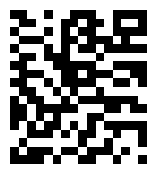

Message corrompu:


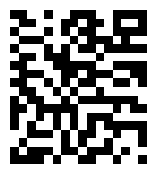

Différence (erreurs):


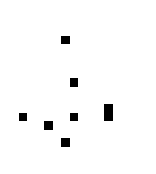

Message décodé: ceci est un message 


In [1603]:
# On encode un message
message = "ceci est un message " # espace a la fin pour avoir un nombre pair de bits, on peut ajouter a notre encodeur la gestion de la longueur du message a la place
print("Message original:", message)
encoded_message = encode_message(message, 16, 16, True)
draw_matrice(encoded_message)

# On ajoute des erreurs
nb_erreurs = 8
error_message = encoded_message.copy()
for i in range(nb_erreurs):
    random_x = np.random.randint(0, error_message.shape[0])
    random_y = np.random.randint(0, error_message.shape[1])
    error_message[random_x, random_y] = 1 if error_message[random_x, random_y] == 0 else 0
print("Message corrompu:")
draw_matrice(error_message)

# Affiche la différence entre le message original et le message corrompu
print("Différence (erreurs):")
draw_matrice(np.logical_xor(encoded_message, error_message))

# On corrige le message
decoded_message = decode_message(error_message, 16, True)
print("Message décodé:", decoded_message)